In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import math
import torch.nn.init as init

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchvision.transforms import Lambda
both_transform = A.Compose([A.Resize(width=256, height=256),], additional_targets={"image0": "image"},)
transform = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        ground_truth = np.array(Image.open(ground_truth_path))
        noisy = np.array(Image.open(noisy_path))
        augmentations = both_transform(image=noisy, image0=ground_truth)
        noisy = augmentations["image"]
        ground_truth = augmentations["image0"]
        ground_truth = transform(image = ground_truth)["image"]
        noisy = transform(image = noisy)["image"]
        return noisy, ground_truth

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    x, y = x.to(DEVICE), y.to(DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [5]:
root_tr = "/kaggle/input/devanagari-denoise-256-8k/devanagari_noise_set_256_8k/train"
root_te = "/kaggle/input/devanagari-denoise-256-8k/devanagari_noise_set_256_8k/val"

In [6]:
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EAM(nn.Module):
    def __init__(self):
        super(EAM, self).__init__()

        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, dilation=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, dilation=2, padding=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, dilation=3, padding=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, dilation=4, padding=4)

        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=1, padding=0)  # Adjusted padding

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        conv1 = F.relu(self.conv2(conv1))

        conv2 = F.relu(self.conv3(x))
        conv2 = F.relu(self.conv4(conv2))

        concat = torch.cat([conv1, conv2], dim=1)
        conv3 = F.relu(self.conv5(concat))
        add1 = x + conv3

        conv4 = F.relu(self.conv6(add1))
        conv4 = self.conv7(conv4)
        add2 = conv4 + add1
        add2 = F.relu(add2)

        conv5 = F.relu(self.conv8(add2))
        conv5 = F.relu(self.conv9(conv5))
        conv5 = self.conv10(conv5)
        add3 = add2 + conv5
        add3 = F.relu(add3)

        gap = self.gap(add3)
        gap = gap.view(gap.size(0), -1)
        gap = gap.view(gap.size(0), gap.size(1), 1, 1)
        conv6 = F.relu(self.conv11(gap))
        conv6 = torch.sigmoid(self.conv12(conv6))

        mul = conv6 * add3
        out = x + mul

        return out

class RIDNet(nn.Module):
    def __init__(self):
        super(RIDNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.eam1 = EAM()
        self.eam2 = EAM()
        self.eam3 = EAM()
        self.eam4 = EAM()
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        eam1 = self.eam1(conv1)
        eam2 = self.eam2(eam1)
        eam3 = self.eam3(eam2)
        eam4 = self.eam4(eam3)
        conv2 = self.conv2(eam4)
        out = x + conv2

        return out


In [8]:
model = RIDNet()

In [9]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [10]:
# Load pre-trained weights
pretrained_weights_path = '/kaggle/input/ridnet-cnn-256/ridnet_cnn_256.pth'
pretrained_dict = torch.load(pretrained_weights_path)
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Update the model weights
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [11]:
import math
import torch.nn as nn
import torch

def psnr(mse, max_pixel_val=255.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
los = nn.MSELoss()
num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_psnr = []
test_losses = []
test_psnr = []
model_save_path = 'unet_nd_model_epoch_{}.pth'
for epoch in range(num_epochs):
    total_psnr_train = 0
    tot_loss_train = 0
    model.train()
    
    optimizer.zero_grad()

    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        o = outputs*0.5+0.5
        c = clean_imgs*0.5+0.5
        mse = los(o*255.0,c*255.0)
        current_psnr = psnr(mse)
        total_psnr_train += current_psnr
        tot_loss_train += loss.item()  # Using loss.item() to accumulate the loss

        loss.backward()  # Calculate gradients

        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients

    avg_psnr_train = total_psnr_train / len(train_loader)
    train_losses.append(tot_loss_train / len(train_loader))
    train_psnr.append(avg_psnr_train)
    model.eval()
    total_psnr_valid = 0
    tot_loss_valid = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in valid_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            o = outputs*0.5+0.5
            c = clean_imgs*0.5+0.5
            mse = los(o*255.0,c*255.0)
            current_psnr = psnr(mse)
            total_psnr_valid += current_psnr
            tot_loss_valid += loss.item()

    avg_psnr_valid = total_psnr_valid / len(valid_loader)
    validation_loss = tot_loss_valid / len(valid_loader)
    test_losses.append(validation_loss)
    test_psnr.append(avg_psnr_valid)
    torch.save(model.state_dict(), model_save_path.format(epoch))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train PSNR: {avg_psnr_train:.4f}, Valid PSNR: {avg_psnr_valid:.4f}")
    save_some_examples(model, valid_loader, epoch, folder="/kaggle/working/evaluation")

Epoch [1/30], Train PSNR: 34.8789, Valid PSNR: 34.8658
Epoch [2/30], Train PSNR: 36.8705, Valid PSNR: 35.7590
Epoch [3/30], Train PSNR: 37.2442, Valid PSNR: 36.2088
Epoch [4/30], Train PSNR: 37.5339, Valid PSNR: 36.7797
Epoch [5/30], Train PSNR: 37.7628, Valid PSNR: 36.9373
Epoch [6/30], Train PSNR: 37.7963, Valid PSNR: 37.1268
Epoch [7/30], Train PSNR: 37.9104, Valid PSNR: 37.1964
Epoch [8/30], Train PSNR: 38.0398, Valid PSNR: 37.5744
Epoch [9/30], Train PSNR: 38.0723, Valid PSNR: 37.1641
Epoch [10/30], Train PSNR: 38.0851, Valid PSNR: 37.5745
Epoch [11/30], Train PSNR: 38.2019, Valid PSNR: 37.6549
Epoch [12/30], Train PSNR: 38.2125, Valid PSNR: 37.5422
Epoch [13/30], Train PSNR: 38.2379, Valid PSNR: 37.7813
Epoch [14/30], Train PSNR: 38.3037, Valid PSNR: 37.6133
Epoch [15/30], Train PSNR: 38.2748, Valid PSNR: 37.2312
Epoch [16/30], Train PSNR: 38.3381, Valid PSNR: 37.4875
Epoch [17/30], Train PSNR: 38.3353, Valid PSNR: 37.7176
Epoch [18/30], Train PSNR: 38.4152, Valid PSNR: 37.3417
E

In [12]:
train_loss = []
test_loss = []
for i in train_losses:
    train_loss.append(i)
for i in test_losses:
    test_loss.append(i)

In [13]:
print("Train_loss:",train_loss[len(train_loss)-1])
print("Test_loss:",test_loss[len(test_loss)-1])

Train_loss: 0.0005433702377171149
Test_loss: 0.00044043560046702623


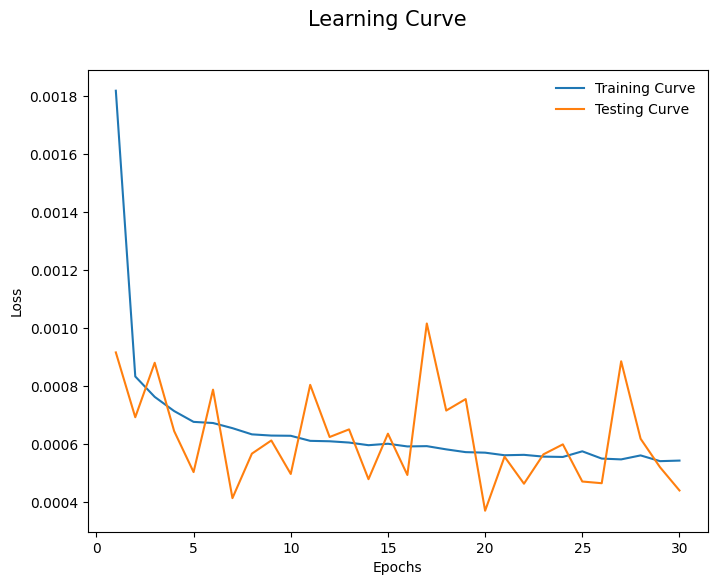

In [14]:
import matplotlib.pyplot as plt
x = [i for i in range(1,num_epochs+1)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("Learning Curve", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(x, train_loss, label="Training Curve")
ax.plot(x, test_loss, label="Testing Curve")
plt.legend(loc="upper right", frameon=False)
plt.show()

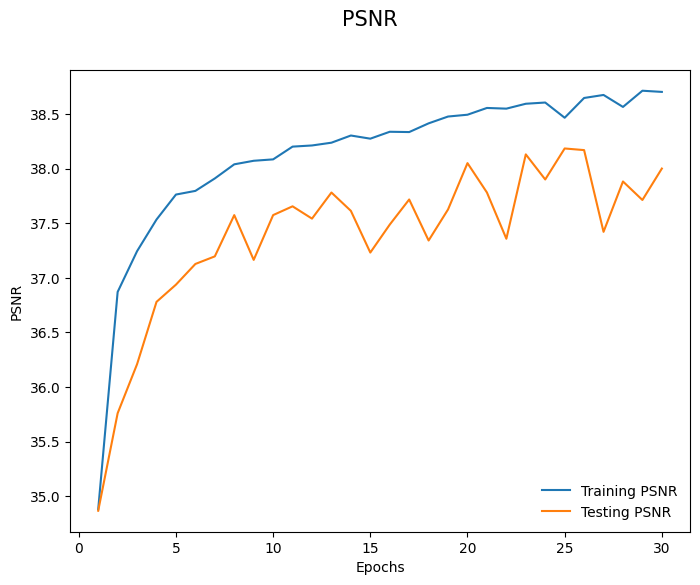

In [15]:
import matplotlib.pyplot as plt
x = [i for i in range(1,num_epochs+1)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('PSNR')
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [16]:
torch.save(model.module.state_dict(), 'model_ridnet_denoise_256_devanagari_fine_tune.pth')